MAE (log-scale): 0.70
RMSE (log-scale): 0.83
R² Score (log-scale): -3.61


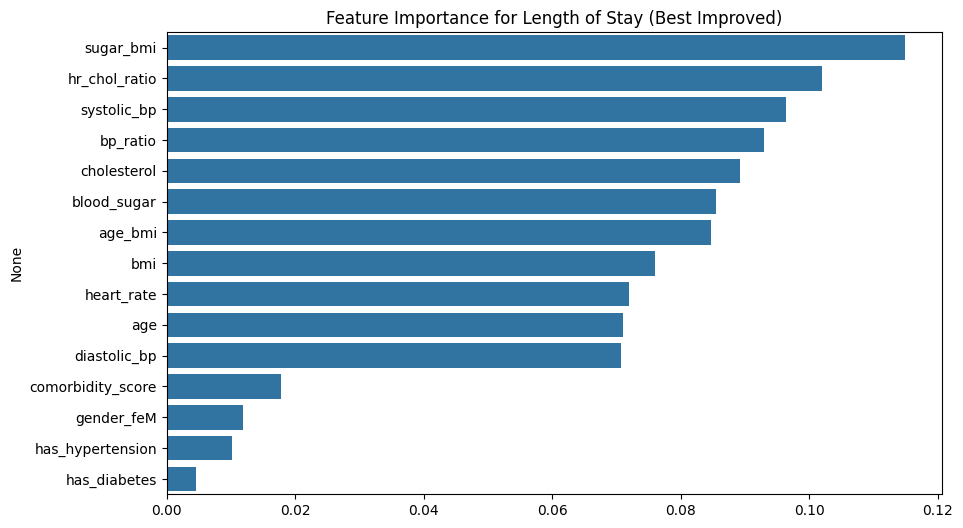

5-Fold CV R² Scores: [-0.02896427 -0.01952386 -0.04409866 -0.07905868  0.01648187]
Mean CV R²: -0.031


In [ ]:
# STEP-4: Length of Stay Regression (Best Improved Version)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load Clean Data

df = pd.read_csv(r"D:\final_project\data\processed\clean_healthcare.csv")


# Feature Engineering

df['age_bmi'] = df['age'] * df['bmi']
df['bp_ratio'] = df['systolic_bp'] / (df['diastolic_bp'] + 1e-3)
df['comorbidity_score'] = df['has_diabetes'] + df['has_hypertension']
df['hr_chol_ratio'] = df['heart_rate'] / (df['cholesterol'] + 1e-3)
df['sugar_bmi'] = df['blood_sugar'] * df['bmi']


# Optional: Target log transform to stabilize LOS

y = df['length_of_stay_days']
y_log = np.log1p(y)  # log(1+LOS)

# Features
X = df.drop(columns=['length_of_stay_days','outcome'])


# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.3, random_state=42
)


# Feature Scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train RandomForest Regressor (Best tuned)

reg_model = RandomForestRegressor(
    n_estimators=300,        # sufficient trees
    max_depth=12,            # limit to prevent overfitting
    min_samples_leaf=2,      # stabilize small leafs
    min_samples_split=5,     # avoid splitting on tiny data
    random_state=42,
    n_jobs=-1
)
reg_model.fit(X_train_scaled, y_train)


# Predictions

y_pred_log = reg_model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # revert log transform


# Evaluation Metrics

mae = mean_absolute_error(y_test, np.log1p(y_pred))
rmse = np.sqrt(mean_squared_error(y_test, np.log1p(y_pred)))
r2 = r2_score(np.log1p(y_test), np.log1p(y_pred))

print(f"MAE (log-scale): {mae:.2f}")
print(f"RMSE (log-scale): {rmse:.2f}")
print(f"R² Score (log-scale): {r2:.2f}")


# Feature Importance

feat_imp = pd.Series(reg_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance for Length of Stay (Best Improved)")
plt.show()


# Optional: Cross-validation check

cv_scores = cross_val_score(reg_model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"5-Fold CV R² Scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.3f}")

